Modern neural networks are becoming increasingly powerful perceptual machines but their ability to perform logic is still rudimentary at best. The early days of AI research focused on logic and symbol manipulation and for many decades computers have had super human logical capabilities (in some respects anyway). Recently there has been a surge of interest in trying combine modern neural architectures with classical symbolic/logical AI. These sorts of systems are starting to be described as "neuro symbolic AI". I think the general idea of incorporating sophisticated exact logical systems into a framework alongside fuzzier more "intuitive" perceptual systems  is a very interesting idea. 

What does this have to do with Sudoku you ask? Sudoku is exactly the sort of problem that is relatively easy to tackle with classical AI techniques and somewhat awkward to tackle using nothing but neural networks (not that it isn't fun and interesting to try see for example the many notebooks using t<a href=https://www.kaggle.com/bryanpark/sudoku/notebooks>this million puzzle sudoku dataset</a>).  

But with a little work you can encode sudoku as one of a standard sort of constraint satisfaction problem  like <a href=https://en.wikipedia.org/wiki/Linear_programming>a linear program</a> or a <a href=bhttps://en.wikipedia.org/wiki/Boolean_satisfiability_problem>boolean satisfiability problem</a>. With such systems you can quickly and efficiently find solutions which you can be extremely confident will be 100% correct. By contrast if I were presented with for example a multi-layer perceptron or convolutional neural net which showed 100% prediction accuracy on a test set of a few hundred thousand boards I would not be convinced that the network truly had learned a function which was actually a perfect sudoku solver, it would be much more likely that it had somehow learned a close (but imperfect) approximation to such a thing. I certainly would not say that such a neural network would "understand" sudoku in any meaningful way. Though if I'm being honest I also do not think that the expression of the rules of sudoku in propositional logic represents a much stronger form of "understanding" in the human sense.

I have a lot more knowledge and experience with neural networks than I do with logical inference. But I have been wanting to add some logic based tools to my toolbox. The ability to do complex exact logical inference is useful even if I never apply it in my work as an ML practitioner. I have some experience with linear programming but I have never used a satisfiability solver before for anything and thinking through how to encode sudoku into a satisfiability problem seemed like it would be a good exercise to help me become more familiar with those sorts of logical systems.

<!-- TEASER_END -->


In [1]:
import numpy as np
import copy
import scipy.optimize
import itertools
import pycosat

import matplotlib.pyplot as plt

In [2]:
plt.rcParams.update({
    "figure.figsize":(12, 6),
    "font.size":15,
})

## Sudoku as a Linear Program

Lets start with how to encode sudoku as a linear program. A linear program is a type of constrained optimization problem where both the constraints and the objective function are linear functions of the variables. In this particular case there is no objective other than to satisfy the constraints and so any objective function will do.  It may not at first seem like sudoku would be the sort of thing which you could "linearize". But it is possible to do if we take advantage of the fact that we have complete freedom in terms of what variables we use to represent a board.

The natural way to represent a sudoku board, solved or unsolved, is of course a 9x9 grid of integers between 1 and 9. Or perhaps I should say that is how you would likely present a sudoku board to a human. But that is not the only possible representation and not necessarily the most convenient way to represent a sudoku board to a computer and it isn't what we will mostly use in this post.

## A More Algorithm Friendly Representation

nstead of a 9x9 grid of variables whose values are between 1 and 9 it turns out to be much nicer to work with a vector of $9*9*9=729$ variables with values between 0 and 1.
These varaibles correspond to every possible combination of row, column, and digit. With a 1 representing that the particular combination of row, column, and digit actually occurs in a given board and a 0 indicates that combination does not occur. 

Lets denote these variables as 

$x_{r,c,d}$ 

So for example $x_{1,2,5}=1$ would indicate that the second column of the first row contained the digit 5. 
and likewise $x_{2,5,3}=0$ would indicate that the digit contained in row 2 column 5 is not a 3. We want these indicator variables to be either exactly 0 or exactly 1 but linear programs only work on convex spaces so we will make do with constraininng the values of x to lie between 0 and 1 inclusive.

$$0 \leq x_{r,c,d} \leq 1$$

Represented in this way a valid sudoku board is one such that for the set of digits,

$$
D = \{1,2,3,4,5,6,7,8,9\}
$$

We can express the constraint that each row have at least one of each digit by summing up indicator variables over columns with one such sum constraint per digit.

$${\large \sum_{c \in D} x_{r,c,d} = 1 ~{\rm for}~r,d~\in D}$$

We can incorporate the same sort ofconstraint for columns by summing over row indexes,

$${\large \sum_{r \in D} x_{r,c,d} = 1~{\rm for}~c,d~\in D} $$


and finally we can ensure that each box contains at least one digit by summing over the (row, column) pairs corresponding to each box,

$${\large \sum_{(r,c) \in box_i} x_{r,c,d} = 1 ~{\rm for}~i,d~\in D}$$

The first time through this excercise those three sets of constraints seemed like enough. After all those three constraints are the rules of sudoku as we tend to explain them to other humans. But strictly speaking there is nothing in the above set of constraints that requires that we assign only a single number to any particular location in the grid. For that we neeed to also add a set of constraints for each grid position that ensures that at least one digit is assigned to it.

$${\large \sum_{d \in D} x_{r,c,d} = 1~{\rm for}~r,c~\in D} $$

This last constraint taken together with the others imply that each cell will be assigned exactly one digit. 

### Initial Board Constraints and Fractional Solutions

But "wait a minute" I can almost hear you say, what is to prevent us from finding "solution" which have entries somewhere between 0 and 1? There is seemingly nothing to prevent us from for example considering a solution with $x_{1,1,1} = 1/2$ and $x_{1,1,2}=1/2$ or any other such fractional solution?. You would be correct in thinking that such solution vectors might indeed be able to satisfy the linear constraints without yeilding proper sudoku boards. You would be right to worry since in fact the above linear equalities actually hold not just for any one particular sudoku board but for all valid sudoku boards. 

The $x$ vector corresponding to any valid sudoku solution will satisfy the above equalities. If that vector consists only of entries which are either exactly 0 or 1 then that vector corresponds to one possible sudoku board. However, any convex combination of two (or more) such vectors will also satisfy the same set of constraints but will have fractional entries and doesn't have any clear interpretation as a proper sudoku board. 

In other words the above linear constraints describe the convex hull of valid sudoku boards instead of a unique sudoku board. But we haven't yet considered the constraints that come from knowing the cells on the board which have already been filled in. Each cell whose value we know adds 9 additional linear constraints specifying the 9 associated entries in the board vector. If the sudoku board in question is well posed then it must have a single unique solution. In terms of the admissible region of solutions for our linear program this translates to the requirement that when we add the extra constraints coming from the known initial cells of the problem the admissible region must shrink down to a single point! To see that this must be the case suppose that the admissible region of the linear program had some amount of extension. If it isn't exactly 0 dimensional (a single point) then the permissible region must be at least 1 dimensional. All of the constraint hyper planes cut exactly through some subset of the vertexes of the convex hull of possible boards and each of these vertexes represent completely valid sudoku boards. Which means that if our constraints are loose enough to include some interior region of improper fractional solutions then that set of permissible solutions must also contain at least 2 vertexes of the convex hull of all sudoku boards, but that would mean that the initial board conditions permitted more than one solution. 

Or to put it simply the requirement that our initial board contains enough information to solve the puzzle is exactly the same as saying that the linear constraints are tight enough to restrict the space of admissible solution vectors to just one point, neat!

## Variable Indexing

It is helpful to be able to translate between any particular combination of row, column, and digit to a single flat variable index (and back). Since this is very much like indexing into a multi dimensional array of shape (9, 9, 9) we can use the numpy utilities for translating between multi dimensional indexes and flat "raveled" indexes. The numpy function ravel_multi_index takes us from a tuple of indexes into a multi dimensional array to an index into a flat array of a given shape, and we can reverse that transform and go from a flat index back to a multi dimensional index using the numpy function unravel_index. This trick is very useful every once in a while.

Doing things this way it is more convenient to begin the indexing at 0 for the digits so we will index what would normally be the digit "1" on the board as number index 0.

In [3]:
#calculate an index for each indicator variable
def var_index(row, col, num, N):
    return int(np.ravel_multi_index((row, col, num), (N, N, N)))

using the same trick we can also easily calculate an index for the 3x3 boxes that each digit belongs to.

In [4]:
#calculate which box each (row,col) pair falls into
def box_index(row, col, N):
    sqrt_n = int(np.sqrt(N))
    assert sqrt_n**2 == N
    return np.ravel_multi_index((row//sqrt_n, col//sqrt_n), (sqrt_n, sqrt_n))

The sudoku rules can be succinctly restated in that each row, column, and box must have exactly one of each digit contained in it. In our expanded set of indicator variables for each (row, column, digit) triplet we can re express this as a sum over certain subsets of indicator variables which are mutually exclusive with each other. Namely exactly one of the indicator variables for any given row and digit combination may be "turned on" and likewise for each column and box. 

For reasons that will become clear later we will compute our constraints in terms of the indexes of these sets of mutually exclusive indicator variables. These will be the indexes of the non-zero entries in our linear constraint matrix for our linear program.

In [5]:
def generate_uniqueness_sets(N):
    row_sets = [] #one example of each digit in each row
    col_sets= [] #one example of each digit in each col
    box_sets = [] #one example of each digit in each box
    cell_sets = [] #every cell has an assigned number
    
    for row in range(N):
        for col in range(N):
            cell_sets.append([var_index(row, col, num, N) for num in range(N)])
    
    box_to_pairs = {}
    for num in range(N):
        for i in range(N): #fixed index
            row_set = []
            col_set = []
            for j in range(N): #index we are summing over
                row_set.append(var_index(i, j, num, N))
                col_set.append(var_index(j, i, num, N))
                if num == 0:
                    cbox = box_index(i, j, N)
                    box_to_pairs[cbox] = box_to_pairs.get(cbox, []) + [(i, j)]
            row_sets.append(row_set)
            col_sets.append(col_set)

    for num in range(N):
        for box_idx in range(N):
            box_set = []
            row_col_pairs = box_to_pairs[box_idx]
            for row, col in row_col_pairs:
                box_set.append(var_index(row, col, num, N))
            box_sets.append(box_set)
            
    return row_sets + col_sets + box_sets + cell_sets

In [6]:
sudoku_uniqueness_sets = generate_uniqueness_sets(N=9)

Lets translate these sets into the coefficients of a set of vectors in dense matrix and take a look.

In [7]:
def to_dense_constraint_matrix(variable_sets, N):
    out_matrix = np.zeros((len(variable_sets), N**3))
    for constraint_index, v_set in enumerate(variable_sets):
        for v_index in v_set:
            out_matrix[constraint_index, v_index] = 1.0
    return out_matrix

In [8]:
shared_constraint_matrix = to_dense_constraint_matrix(sudoku_uniqueness_sets, N=9)

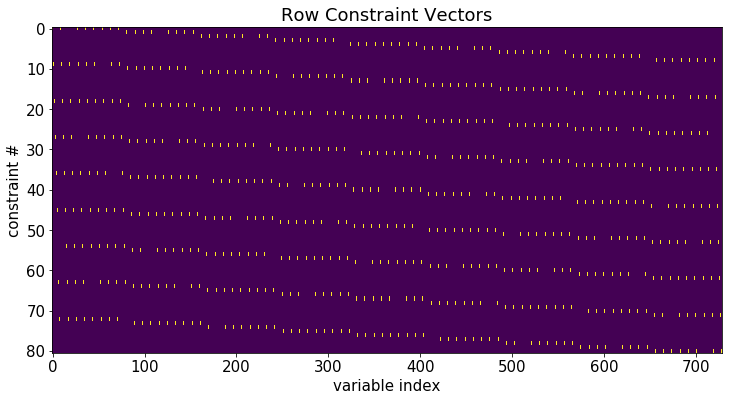

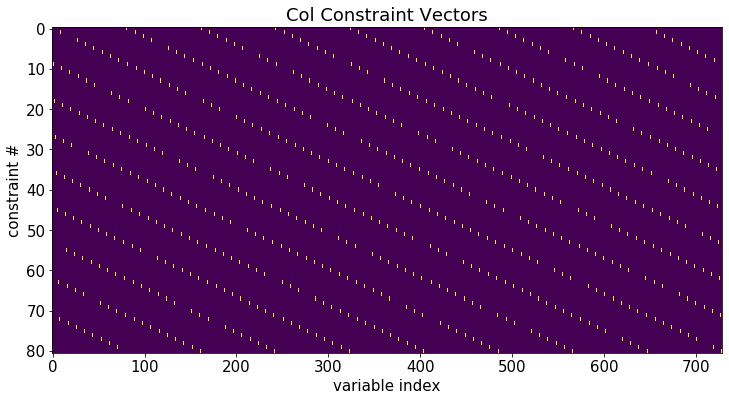

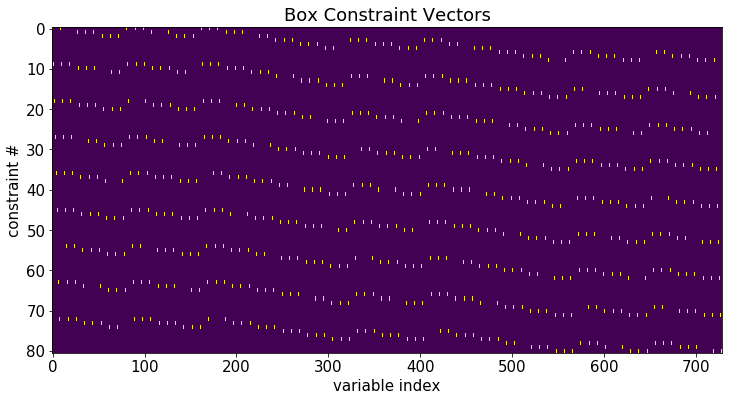

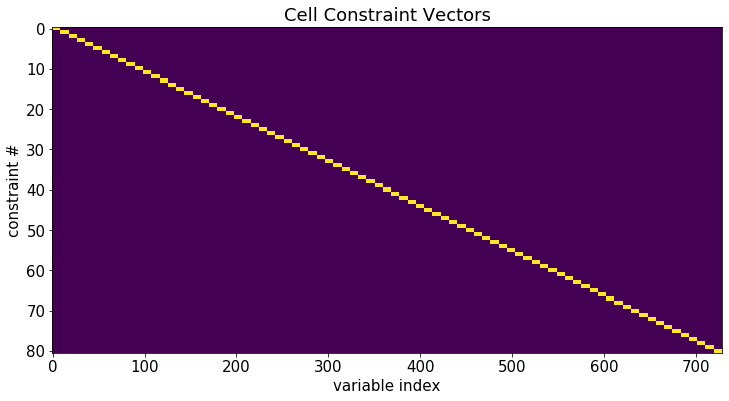

In [9]:
plt.imshow(shared_constraint_matrix[:81], aspect="auto")
plt.title("Row Constraint Vectors")
plt.ylabel("constraint #")
plt.xlabel("variable index")
plt.show()

plt.imshow(shared_constraint_matrix[81:2*81], aspect="auto")
plt.title("Col Constraint Vectors")
plt.ylabel("constraint #")
plt.xlabel("variable index")
plt.show()

plt.imshow(shared_constraint_matrix[2*81:3*81], aspect="auto")
plt.title("Box Constraint Vectors")
plt.ylabel("constraint #")
plt.xlabel("variable index")
plt.show()

plt.imshow(shared_constraint_matrix[3*81:], aspect="auto")
plt.title("Cell Constraint Vectors")
plt.ylabel("constraint #")
plt.xlabel("variable index")
plt.show()

## Test Board

The dot product of the vector of indicator variables with each one of these constraint vectors tests one of the sum constraints mentioned at the beginning of this post. If the dot product of the vector corresponding to a particular board with each of the constraint vectors is equal to 1 then that board is a valid sudoku board (assuming that the entries in the vector can be equal to either 0 or 1).

Lets take a look at a real sudoku puzzle and solution and check that the corresponding vector of indicator variables has a dot product of 1 with each of our constraint vectors. The below puzzle is gleaned from the million puzzle dataset I mentioned above.

As mentioned earlier it simplifies our indexing to subtract 1 from the entries on the sudoku board so we will let the entries on a sudoku board run from 0 to 8 instead of 1 to 9, and let an entry of -1 indicate an unknown entry.

In [10]:
test_problem = "004300209005009001070060043006002087190007400050083000600000105003508690042910300"
test_solution = "864371259325849761971265843436192587198657432257483916689734125713528694542916378"

def board_str_to_array(board_str, zero_index_nums=True):
    arr = np.array(list(map(int, board_str))).reshape((9, 9))
    if zero_index_nums:
        arr -= 1
    return arr
    
test_solution = board_str_to_array(test_solution)
test_problem = board_str_to_array(test_problem)

In [11]:
test_solution

array([[7, 5, 3, 2, 6, 0, 1, 4, 8],
       [2, 1, 4, 7, 3, 8, 6, 5, 0],
       [8, 6, 0, 1, 5, 4, 7, 3, 2],
       [3, 2, 5, 0, 8, 1, 4, 7, 6],
       [0, 8, 7, 5, 4, 6, 3, 2, 1],
       [1, 4, 6, 3, 7, 2, 8, 0, 5],
       [5, 7, 8, 6, 2, 3, 0, 1, 4],
       [6, 0, 2, 4, 1, 7, 5, 8, 3],
       [4, 3, 1, 8, 0, 5, 2, 6, 7]])

In [12]:
def board_to_indicator_variables(arr, as_clause_list=True):
    variables = []
    N = arr.shape[0]
    for row in range(N):
        for col in range(N):
            num = arr[col, row]
            if num >= 0:
                ci = var_index(row, col, num, N)
                variables.append(ci)
    if as_clause_list:
        variables = [[cvar] for cvar in variables]
    return variables

In [13]:
def board_to_indicator_vector(arr):
    N = arr.shape[0]
    vec = np.zeros(N**3)
    for ci in board_to_indicator_variables(arr, as_clause_list=False):
        vec[ci] = 1.0
    return vec

In [14]:
x_sol = board_to_indicator_vector(test_solution)

In [15]:
np.dot(shared_constraint_matrix, x_sol)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

The vector corresponding to the solved board does indeed satisfy all our linear constraints. That is a nice little sanity check on our above code.

Now lets see if we can coax a linear program solver into finding this solution starting from the partially filled in puzzle.

# Scipy Optimize Linprog

There is a modestly powerful linear program solver available in the scipy.optmize module <a href=https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.linprog.html>linprog</a>. Since most people will already have this in their python distribution of choice lets start there.

Conveniently we can encode the initial board conditions as additional existence + uniqueness constraints on individual indicator variables so we can just reuse the same code we used for generating the shared row/colmn/box constraints.

In [16]:
initial_constraints = to_dense_constraint_matrix(
    board_to_indicator_variables(test_problem),
    N=9,
)

In [17]:
total_constraints = np.vstack([
    shared_constraint_matrix,
    initial_constraints,
])

opt_results = scipy.optimize.linprog(
    c=np.zeros(9**3), 
    A_eq=total_constraints, 
    b_eq=np.ones(len(total_constraints)),
    bounds=(0, 1),
)

/home/tim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  # Remove the CWD from sys.path while we load stuff.


In [18]:
opt_results["status"] #0 indicates success

0

In [19]:
np.dot(shared_constraint_matrix, opt_results["x"])

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

Great! the linear program found a solution which satisfies all our constraints which should mean that we have solved the puzzle! This is a well formed puzzle so there can be just one solution and so the solution vector should be exactly equal to the indicator vector we calculated above. 

Lets make a transform which accepts a valid indicator variable vector and returns a the corresponding board so that we can take a look at the result and see if it is indeed correct.

In [20]:
def indicators_to_board(variables, N):
    shape = (N, N, N)
    rows, cols, nums = np.unravel_index(variables, shape)
    board = -1*np.ones((N, N), dtype=int) #fill with -1
    for r, c, n in zip(rows, cols, nums):
        cval = board[c, r]
        board[c, r] = n
    
    return board

def vector_to_board(vec, threshold=0.5):
    N = int(np.around(np.power(len(vec), 1/3.0)))
    true_vars = np.where(vec > 0.5)[0]
    return indicators_to_board(true_vars, N)

First as a sanity check lets make sure that this acts as an inverse of our board to indicator vector encoding up above by passing a few hundred random boards through them.

In [21]:
for i in range(100):
    random_board = np.random.randint(0, 9, size=(9, 9))
    vec = board_to_indicator_vector(random_board)
    inv_vec = vector_to_board(vec)
    assert np.max(np.abs(inv_vec-random_board)) < 0.001

So far so good, now lets appy this same transform to the prospective solution vector and see what we found.

In [22]:
test_solution

array([[7, 5, 3, 2, 6, 0, 1, 4, 8],
       [2, 1, 4, 7, 3, 8, 6, 5, 0],
       [8, 6, 0, 1, 5, 4, 7, 3, 2],
       [3, 2, 5, 0, 8, 1, 4, 7, 6],
       [0, 8, 7, 5, 4, 6, 3, 2, 1],
       [1, 4, 6, 3, 7, 2, 8, 0, 5],
       [5, 7, 8, 6, 2, 3, 0, 1, 4],
       [6, 0, 2, 4, 1, 7, 5, 8, 3],
       [4, 3, 1, 8, 0, 5, 2, 6, 7]])

In [23]:
vector_to_board(opt_results["x"])

array([[7, 5, 3, 2, 6, 0, 1, 4, 8],
       [2, 1, 4, 7, 3, 8, 6, 5, 0],
       [8, 6, 0, 1, 5, 4, 7, 3, 2],
       [3, 2, 5, 0, 8, 1, 4, 7, 6],
       [0, 8, 7, 5, 4, 6, 3, 2, 1],
       [1, 4, 6, 3, 7, 2, 8, 0, 5],
       [5, 7, 8, 6, 2, 3, 0, 1, 4],
       [6, 0, 2, 4, 1, 7, 5, 8, 3],
       [4, 3, 1, 8, 0, 5, 2, 6, 7]])

In [24]:
np.max(np.abs(test_solution - vector_to_board(opt_results["x"])))

0

Woot! The solution to the linear program netted us the correct solution to the sudoku puzzle.

Like I mentioned above this works because the linear constraints are tight and so there is only a single unique point in the space of 729 indicator variables that satisfies them all. However if the puzzle being posed had more than one answer then we would get back a vector which could be any vector within the convex hull of the vectors corresponding to possible solutions. 

Lets get rid of enough of the initial cell value conditions to make sure that the puzzle doesn't have a unique solution and solve the linear program again and see what happens.

In [25]:
total_constraints = np.vstack([
    shared_constraint_matrix,
    initial_constraints[:15],
])

opt_results = scipy.optimize.linprog(
    c=np.zeros(9**3), 
    A_eq=total_constraints, 
    b_eq=np.ones(len(total_constraints)),
    bounds=(0, 1),
)

/home/tim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  # Remove the CWD from sys.path while we load stuff.


In [26]:
opt_results["status"] #0 is success

0

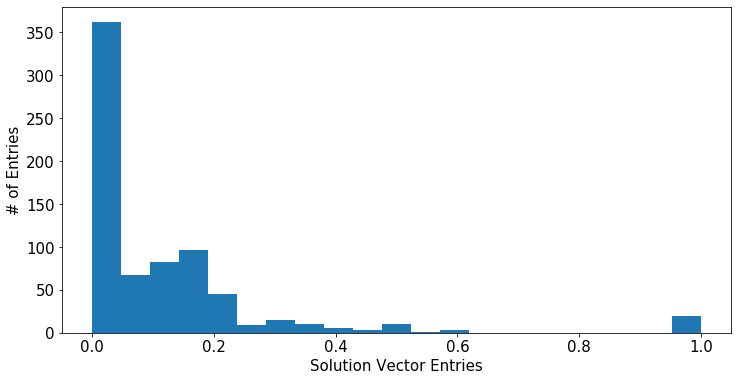

In [27]:
plt.hist(opt_results["x"], 21);
plt.xlabel("Solution Vector Entries")
plt.ylabel("# of Entries");

In [28]:
vector_to_board(opt_results["x"])

array([[-1,  5,  3,  2, -1, -1, -1, -1, -1],
       [-1, -1,  4, -1, -1, -1, -1, -1, -1],
       [-1,  6,  0, -1,  5, -1, -1, -1, -1],
       [ 3,  2,  5, -1, -1, -1, -1, -1, -1],
       [ 0,  8,  7,  5, -1, -1, -1, -1, -1],
       [-1,  4,  6, -1, -1, -1, -1, -1, -1],
       [ 5,  7,  8, -1, -1, -1, -1, -1, -1],
       [ 6,  0,  2,  4, -1,  5, -1, -1, -1],
       [ 4,  3,  1,  8, -1, -1, -1, -1, -1]])

# Sudoku and Boolean Satisfiability 

Even though we can encode the constraints of a sudoku problem as a linear program the fact that we haven't even used the objective function is certainly a sign that the language of linear program optimization is a little bit of an awkward match for sudoku. 

Sudoku is at its core a very particular kind of logic puzzle. Any (finite) logic puzzle can be rewritten into an equivalent set of logical statements which deal only with binary true/false variables. The general class of such problems is called a <a href=https://en.wikipedia.org/wiki/Boolean_satisfiability_problem>boolean satisfiability problem</a>.  In fact any sort of problem for which a computer can compute a solution can be translated into a boolean satisfiability problem or more precisely boolean satisfiability problems are <a href=https://en.wikipedia.org/wiki/NP-completeness>NP-complete</a>.

In order to translate sudoku into a boolean satisfiability problem we need to do three things. 

* Encode the board state into a series of true/false statements which we call "variables"
* Encode sudoku game rules as boolean logic statements in terms of the board state variables
* Translate all these statements into Conjunctive Normal Form


Thankfully we have already done the first step of figuring out a good way to encode the board state in a series of indicator variables up above. The second and third steps will require a little additional work on our part. Lets start with the third. 

<a href=https://en.wikipedia.org/wiki/Conjunctive_normal_form>Conjunctive Normal Form (CNF)</a> is a standard way to encode a series of logical statements over boolean variables in order to make manipulation and solving algorithms easier to code and reason about. In boolean algebra the OR'ing together of two statements is called a "disjunction" denoted by $\lor$ and the AND'ing together of variables is called a "Conjunction" and is denoted by $\land$ and the negation of a variable (NOT) is denoted $\lnot$. 

In a general boolean statement we can apply conjunction, disjunction, and negation to any variables or any combination of variables in any order. A statement is said to be in CNF if it looks like a conjunction of disjunctions of base variables or their negations.

So for example let A and B be our basic boolean variables 

$$\lnot(A \lor B)$$

is not in CNF because we can only negate the base variables not whole statements. The equivalent CNF statement in this particular case happens to be one of <a href=https://en.wikipedia.org/wiki/De_Morgan%27s_laws>de Morgan's laws</a>.

$$
\lnot(A \lor B) = \lnot A \land \lnot B
$$

and something like 

We can always translate any boolean statement into an equivalent statement in CNF though figuring out exactly how to do so can be a little tricky. 

## Pycosat

The boolean satisfiability tool that we will be using is <a href=https://pypi.org/project/pycosat/>pycosat</a>, which is a python wrapper for the picosat solver. The pycosat documentation seemed a little opaque to me and it took me a little while to figure out how to translate between its list of lists of integers format and the associated CNF. 

For pycosat we specify a list of clauses with each clause being a list of integers. A positive integer represents a base boolean variable and the negative of that integer represents the negation of the corresponding variable. The individual clauses are then combined together by conjunction.

So the python list,

In [29]:
cnf = [[-1, 2], [-2, 3], [-3]]

Represents the statement

$$
(\lnot x_1 \lor x_2) \land (\lnot x_2 \lor x_3) \land \lnot x_3
$$

Which can only be true if all three of $x_1, x_2, x_3$ are false.

In [30]:
pycosat.solve(cnf)

[-1, -2, -3]

## Quantified Logic

When I first sat down to figure out how to try and encode the rules of sudoku into a set of boolean statements (any statements not necessarily in CNF) I completely drew a blank. I tried a few different things but I simply couldn't wrap my head around the problem at all. Eventually I realized that what I needed was a set of higher level statement which would be more useful to me as a human and which I could also compile down into a collection of low level boolean clauses.

It is often much more natural to deal in terms of <a href=https://en.wikipedia.org/wiki/Quantifier_(logic)>quantifiers</a> which are logical statements about the sizes of sets. The most common quantifiers, which you are almost certain to be famiiliar with are "there exists" $\exists$ and "for all" $\forall$. 

In the case of sudoku I realized that what I really needed was a high level statement that in particular groups of indicator variables that there was exactly one of them that was true. In the language of linear programming this worked out to saying that the sum over those groups of indicator variables was equal to 1. 

##  The "Exactly One Of " Quantifier

Translating the statement that a particular set of indicator variables $\{x_1, x_2...\}$ has exactly one true member into CNF turns out to be a little tricky. We can decompose the statement into two parts, at least one of the variables must be true and at most one of the variables can be true. 

Expressing "at least one of these variables is true in CNF is easy it is just the disjunction of all the variables in that set. 

$x_1 \lor x_2 \lor x_3 \dots$

But the statement "at most one of these variables is true" doesn't have an immediately obvious translation into CNF. But a little googling reveals a good trick for this.

Suppose that more than one of the variables were to be true. Is there an easy way that we can detect that situation via some statements in CNF? Well if there is a pair of statements both of which are true then for that pair of statements $(\lnot x_i \lor \lnot x_j)$ will be false. But if only one of the base variables is true then all such negation pairs cannot be true since at least one variable in each clause containing more than one variable must be false. 

Therefore the conjunction of the negations of all possible pairings of the base variables is true if and only if at most one of the base variables is true. That is quite a moutful but fortunately it is maybe a little easier to put succinctly into code than it is to say in words.

Lets make a set of helper functions which take lists of integer variable indentifiers and translate them into the appropriate lists of clauses in CNF. 

In [31]:
def at_least_one_of(variables):
    return [copy.copy(variables)]#copy the variable list to prevent weird in memory modification problems

def at_most_one_of(variables):
    clauses = []
    for i1 in range(len(variables)):
        for i2 in range(i1+1, len(variables)):
            clauses.append([-1*variables[i1], -1*variables[i2]])
    return clauses

def exactly_one_of(variables):
    clauses = at_least_one_of(variables)
    clauses.extend(at_most_one_of(variables))
    return clauses

With these functions in hand we can easily leverage the same set of constraint sets that we generated up above to create a set of clauses in CNF which encode the rules of sudoku as a satisfiability problem. 

There is just one additional wrinkle to deal with which is that because we chose to 0 index the variables the indicator variable that corresponds to labeling row=0,col=0,num=0 is indexed by variable 0. But because pycosat uses the sign of the integer label for each variable to indicate negation it does not allow variables to be referred to by the integer 0. So to fix this we will need to add 1 to all of the variable indexes we used above for the linear program solving stuff. 

In [32]:
shared_clauses = []

for uset in sudoku_uniqueness_sets:
    shared_clauses.extend(
        exactly_one_of(
            [v+1 for v in uset]
        )
    )

In [33]:
len(shared_clauses)

11988

In [34]:
initial_clauses = [[v+1 for v in l] for l in board_to_indicator_variables(test_problem)]

In [35]:
len(initial_clauses)

35

In [36]:
combined_clauses = shared_clauses + initial_clauses

In [37]:
pycosat_solution = np.array(pycosat.solve(combined_clauses))
pycosat_solution = pycosat_solution[pycosat_solution > 0] -1#get the positive indicator variable indexes

indicators_to_board(pycosat_solution, N=9)

array([[7, 5, 3, 2, 6, 0, 1, 4, 8],
       [2, 1, 4, 7, 3, 8, 6, 5, 0],
       [8, 6, 0, 1, 5, 4, 7, 3, 2],
       [3, 2, 5, 0, 8, 1, 4, 7, 6],
       [0, 8, 7, 5, 4, 6, 3, 2, 1],
       [1, 4, 6, 3, 7, 2, 8, 0, 5],
       [5, 7, 8, 6, 2, 3, 0, 1, 4],
       [6, 0, 2, 4, 1, 7, 5, 8, 3],
       [4, 3, 1, 8, 0, 5, 2, 6, 7]])

In [38]:
test_solution

array([[7, 5, 3, 2, 6, 0, 1, 4, 8],
       [2, 1, 4, 7, 3, 8, 6, 5, 0],
       [8, 6, 0, 1, 5, 4, 7, 3, 2],
       [3, 2, 5, 0, 8, 1, 4, 7, 6],
       [0, 8, 7, 5, 4, 6, 3, 2, 1],
       [1, 4, 6, 3, 7, 2, 8, 0, 5],
       [5, 7, 8, 6, 2, 3, 0, 1, 4],
       [6, 0, 2, 4, 1, 7, 5, 8, 3],
       [4, 3, 1, 8, 0, 5, 2, 6, 7]])

# A Sudoku Generator

Now that we have made a couple of sudoku solvers lets go one step further and figure out how to generate random sudoku puzzles which have a unique solution and a minimal unique set of cells specified. I first pick a random valid solution board and then do a random sweep through all the cells removing them if that doesn't make the puzzle have a non-unique solution. 

The resulting puzzles mostly have a number of specified cells somewhere in the range of 22 to 26. The absolute minimum number of cells that can be specified in a 9x9 sudoku puzzle is 17 (something that was just recently <a href=https://arxiv.org/abs/1201.0749>proved</a>). So these puzzles are perhaps not the absolutely most minimal possible for each corresponding solution board but they aren't too far off either.

In [39]:
def generate_puzzle(
    N,
    shared_clauses=None,
    n_seeds_max=10,
):
    if shared_clauses is None:
        #generate the clauses encoding the rules
        shared_clauses = []
        for uset in generate_uniqueness_sets(N):
            shared_clauses.extend(
                exactly_one_of(
                    [v+1 for v in uset]
                )
            )
    
    seed_problem = -1*np.ones((N, N), dtype=int)

    #some random initial values to act as a seed
    row_order = np.argsort(np.random.random(N))
    col_order = np.argsort(np.random.random(N))
    values = np.argsort(np.random.random(N))

    for r, c, v in zip(row_order, col_order, values):
        seed_problem[r, c] = v

    initial_clauses = [[v+1 for v in l] for l in board_to_indicator_variables(seed_problem)]

    viable_solutions = list(itertools.islice(pycosat.itersolve(
        shared_clauses+initial_clauses
    ), n_seeds_max))
    
    solution_clause = viable_solutions[np.random.randint(len(viable_solutions))]
    solution_negation = [-1*v for v in solution_clause]
    csol = np.array(solution_clause)
    csol = csol[csol > 0] -1#get the positive indicator variable indexes
    
    solution_board = indicators_to_board(csol, N=N)
    
    puzzle = solution_board.copy()
    
    proposed = puzzle.copy()
    footprint = np.stack(np.where(proposed >= 0), axis=1)
    #permute the traversal order of the cells
    perm = np.argsort(np.random.random(len(footprint)))
    footprint = footprint[perm]

    for i1, i2 in footprint:
        proposed[i1, i2] = -1 #erase an entry
        initial_clauses = [[v+1 for v in l] for l in board_to_indicator_variables(proposed)]
        #check if a different solution has become possible
        sol = pycosat.solve(shared_clauses+initial_clauses+[solution_negation])
        if sol == 'UNSAT':
            #original solution remains unique
            puzzle = proposed.copy()
        else:
            #that change allowed additional solutions lets roll it back
            proposed = puzzle.copy()
    
    return puzzle
            

In [40]:
puzzle = generate_puzzle(9)

In [41]:
puzzle+1

array([[0, 6, 0, 1, 0, 0, 0, 7, 0],
       [7, 0, 2, 0, 4, 0, 0, 0, 1],
       [8, 0, 0, 0, 9, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 2, 0, 0, 4],
       [3, 8, 0, 0, 0, 4, 2, 0, 0],
       [0, 0, 4, 0, 3, 7, 0, 0, 0],
       [4, 3, 9, 0, 0, 0, 0, 0, 8],
       [0, 0, 0, 0, 0, 0, 0, 0, 2],
       [0, 2, 0, 0, 0, 0, 5, 0, 6]])

In [42]:
np.sum(puzzle >= 0)

26

And we can also generate examples of expanded sudoku for larger boards. Though these take quite a while to generate. 16x16 doesn't take too long but 25x25 takes quite a while and I didn't even try 36x36 or larger. 

In [43]:
puzzle = generate_puzzle(16)

In [44]:
puzzle + 1

array([[16,  0,  0,  6,  0,  0,  0,  0,  0, 11, 10,  8,  0,  2,  0,  0],
       [ 0,  0,  0,  4,  0,  0,  0,  0,  0,  0,  0,  1, 13,  0,  6,  5],
       [ 0,  0,  7,  0, 11,  0,  0,  0,  0,  0,  0,  3,  0,  0,  0, 14],
       [ 0,  0,  0,  0, 14,  0,  0,  5,  0,  0,  0,  0, 16,  0,  9, 11],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 11,  8,  0,  7,  0,  1,  0,  0],
       [11,  9,  0,  0,  0, 16,  0,  8, 10,  0,  2,  0,  0,  7,  0,  0],
       [ 0, 15,  0,  0,  9, 14,  0,  0,  0,  0, 16,  0,  0,  0,  5,  0],
       [ 0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  9,  0,  0, 15, 10],
       [ 0,  0, 16,  0,  0,  0, 15, 12,  0,  0,  0,  0,  2,  0,  1,  7],
       [ 7,  0,  0, 10,  8,  0, 14,  0,  2,  0,  0, 12,  6,  5,  0,  0],
       [ 6,  0, 13,  8,  0,  0,  0,  0,  0,  0, 15,  0,  0,  9,  0,  4],
       [ 0,  0, 12,  3,  6,  1,  0,  0,  9,  4,  0,  0,  0, 15,  0,  0],
       [ 0,  0, 14,  0,  3,  7,  0,  0,  0,  0,  6,  0,  0,  0,  0,  0],
       [ 0,  0, 11,  0,  0,  0, 10,  0,  0,  2,  0,

In [45]:
np.sum(puzzle >= 0)

90